# Predicting hospitalization times
## Nádia Soares, Rafael Santos, Tiago Ribeiro


---



The goal of this project is to predict the hospitalization times given the MIMIC-III dataset on hospitalization events. The data includes information about the patient, ICU, medical exams that were performed and their results, among other variables.

This notebook presents an exploratory data analysis using Seaborn, model creation and evaluation using Keras with a TensorFlow backend. It was created to run on a PySpark cluster, which, in our case, was deployed on Google Cloud.

---

## The following commands need to be executed outside the python interpreter:

* gsutil cp gs:/.../*.GZ .
* gsutil cp gs:/.../*.CSV .

* gunzip *.GZ

* sudo hadoop fs -put EVENTS.csv
* sudo hadoop fs -put ADMISSIONS.csv
* sudo hadoop fs -put DIAGNOSES_ICD.csv
* sudo hadoop fs -put D_ICD_DIAGNOSES.csv
* sudo hadoop fs -put D_ITEMS.csv


---

## (1) Definition of basic functions:

In [25]:
if __name__ == "__main__" :
    # This block is required to run the program from the command line
    # in interface with a single Spark instance
    from pyspark import SparkContext
    from pyspark.sql import SparkSession
    
    spark = SparkSession\
        .builder\
        .appName("BDCCp2")\
        .master("local[*]")\
        .getOrCreate()
        
    
    sc = spark.sparkContext
    sc.setLogLevel("WARN")

In [26]:
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType,IntegerType
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math

import pathlib

import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn import preprocessing

import seaborn as sns

In [27]:
def readCSV(file, debug=False):
    if debug:
        print('Reading ' + file)
    return spark.read.csv(file, inferSchema=True, header=True)

def readParquet(file, debug=False): 
    if debug:
        print('Reading ' + file)
    return spark.read.parquet(file)

def writeCSV(df, path): 
    df.write.csv(path, header=True, mode='overwrite')

def writeParquet(df,path):
    df.write.mode("overwrite").parquet(path)

In [28]:
# Define F.array_intersect if not defined (Spark version < 2.4)
if not hasattr(F,'array_intersect'):
    F.array_intersect = spark.udf\
        .register('array_intersect', 
           lambda x,y: list(set(x) & set(y)), ArrayType(IntegerType()))

# Define F.array_union if not defined (Spark version < 2.4)
if not hasattr(F,'array_union'):
    F.array_union = spark.udf\
        .register('array_union', 
            lambda x,y: list(set(x) | set(y)), ArrayType(IntegerType()))

---

## <span style="color:red"> Note: </span> If the parquet files already exist, jump to **7!** 

---

## (2) Load the data:

In [ ]:
database = readCSV('EVENTS.csv', False)

In [ ]:
writeParquet(database,"database.parquet")
#22:32 - 23:14

In [ ]:
admissions = readCSV('ADMISSIONS.csv', False)

In [ ]:
writeParquet(admissions,"admissions.parquet")

In [ ]:
diagnoses_icd = readCSV('DIAGNOSES_ICD.csv', False)

In [ ]:
writeParquet(diagnoses_icd,"diagnoses_icd.parquet")

In [ ]:
d_icd_diagnoses = readCSV('D_ICD_DIAGNOSES.csv', False)

In [ ]:
writeParquet(d_icd_diagnoses,"d_icd_diagnoses.parquet")

In [ ]:
d_icd_procedures = readCSV('D_ICD_PROCEDURES.csv', False)

In [ ]:
writeParquet(d_icd_procedures,"d_icd_procedures.parquet")

In [ ]:
d_items = readCSV('D_ITEMS.csv', False)

In [ ]:
writeParquet(d_items,"d_items.parquet")

## (3) Generate Tempos dataset

In [ ]:
tempos = database\
    .groupby('SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID')\
    .agg(F.min('CHARTTIME').alias('first_timestamp'),F.max('CHARTTIME').alias('last_timestamp'))


tempos = tempos.withColumn('duration', 
                           (F.unix_timestamp(F.col('last_timestamp')) -
                            F.unix_timestamp(F.col('first_timestamp')))/60)


In [ ]:
writeParquet(tempos,"tempos.parquet")
#22:12 - 22:31

## (4) Generate 24h dataset

In [ ]:
join_condition = [database.SUBJECT_ID == tempos.SUBJECT_ID , \
                  database.HADM_ID == tempos.HADM_ID , \
                  database.ICUSTAY_ID == tempos.ICUSTAY_ID]

database24h = database\
    .join(tempos,join_condition)\
    .filter(F.unix_timestamp(database.CHARTTIME) < F.unix_timestamp(tempos.first_timestamp) + (86400))\
    .select(database.SUBJECT_ID,\
            database.HADM_ID,\
            database.ICUSTAY_ID,\
            database.ITEMID,\
            database.CHARTTIME,\
            database.CGID,\
            database.VALUE,\
            database.VALUENUM,\
            database.VALUEUOM)

    
# 86400 = 60s * 60min * 24h

In [ ]:
writeParquet(database24h,"database24h.parquet")

## (5) Generate aggregation of the first 24 hours

In [ ]:
agg24h = database24h\
    .drop('CHARTTIME')\
    .drop('CGID')\
    .drop('VALUE')\
    .drop('VALUEUOM')\
    .groupby('SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID','ITEMID')\
    .agg(F.min('VALUENUM').alias('min_value'),\
         F.max('VALUENUM').alias('max_value'),\
         F.avg('VALUENUM').alias('avg_value'),\
         F.count('VALUENUM').alias('count'),\
    )

In [ ]:
writeParquet(agg24h,"agg24h.parquet")

## (6) Generate final Pandas dataframe

In [ ]:
%%time

icustay_df = agg24h.join(tempos,tempos.ICUSTAY_ID == agg24h.ICUSTAY_ID)\
                   .select(agg24h.SUBJECT_ID, agg24h.HADM_ID, agg24h.ICUSTAY_ID, agg24h.ITEMID, 
                           agg24h.min_value, agg24h.max_value, agg24h.avg_value, tempos.duration)

# Convert spark dataframe to pandas dataframe
icustay_df = icustay_df.toPandas()

# Replace NaN values with 1
icustay_df.fillna(1, inplace=True)

# Pivot table
icustay_df = icustay_df.pivot_table('avg_value', ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'duration'], 'ITEMID')
icustay_df.reset_index(inplace=True)
icustay_df.columns = icustay_df.columns.astype(str)

# Replace NaN values with 0
icustay_df.fillna(0, inplace=True)

In [ ]:
# Serialize (pickle) to binary python object
icustay_df.to_pickle('cached_dataframe.pkl')

---

## (7) Read parquet files

In [ ]:
database = readParquet("database.parquet")
database.cache()

In [ ]:
admissions = readParquet("admissions.parquet")
admissions.cache()

In [ ]:
diagnoses_icd = readParquet("diagnoses_icd.parquet")
diagnoses_icd.cache()

In [ ]:
d_icd_diagnoses = readParquet("d_icd_diagnoses.parquet")
d_icd_diagnoses.cache()

In [ ]:
d_icd_procedures = readParquet("d_icd_procedures.parquet")
d_icd_procedures.cache()

In [14]:
d_items = readParquet("d_items.parquet")
d_items.cache()

DataFrame[ROW_ID: int, ITEMID: int, LABEL: string, ABBREVIATION: string, DBSOURCE: string, LINKSTO: string, CATEGORY: string, UNITNAME: string, PARAM_TYPE: string, CONCEPTID: string]

In [15]:
tempos = readParquet("tempos.parquet")
tempos.cache()

DataFrame[SUBJECT_ID: int, HADM_ID: int, ICUSTAY_ID: int, first_timestamp: timestamp, last_timestamp: timestamp, duration: double]

In [16]:
database24h = readParquet("database24h.parquet")
database24h.cache()

DataFrame[SUBJECT_ID: int, HADM_ID: int, ICUSTAY_ID: int, ITEMID: int, CHARTTIME: timestamp, CGID: int, VALUE: string, VALUENUM: double, VALUEUOM: string]

In [17]:
agg24h = readParquet("agg24h.parquet")
agg24h.cache()

DataFrame[SUBJECT_ID: int, HADM_ID: int, ICUSTAY_ID: int, ITEMID: int, min_value: double, max_value: double, avg_value: double, count: bigint]

In [29]:
icustay_df = pd.read_pickle('cached_dataframe.pkl')
icustay_df.head()

ITEMID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,duration,1,2,3,4,5,6,...,228442,228443,228444,228445,228446,228447,228448,228449,228450,228451
0,2,163353,243653,100.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,145834,211552,8580.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,185777,294638,2251.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,178980,214757,15.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6,107064,228232,5250.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---

# (8) Exploratory data analysis

In [14]:
icustay_df.head()

ITEMID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,duration,1,2,3,4,5,6,...,228442,228443,228444,228445,228446,228447,228448,228449,228450,228451
0,2,163353,243653,100.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,145834,211552,8580.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,185777,294638,2251.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,178980,214757,15.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6,107064,228232,5250.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
icustay_df.shape

(61301, 4391)

CPU times: user 64 ms, sys: 0 ns, total: 64 ms
Wall time: 63 ms


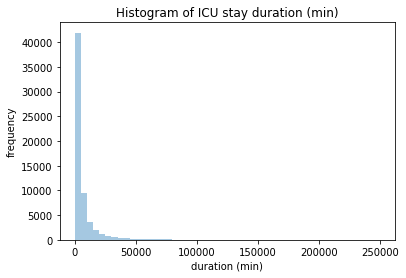

In [12]:
%%time
sns.distplot(icustay_df['duration'], kde=False)

# Add labels
plt.title('Histogram of ICU stay duration (min)')
plt.xlabel('duration (min)')
plt.ylabel('frequency')

CPU times: user 436 ms, sys: 20 ms, total: 456 ms
Wall time: 57 s


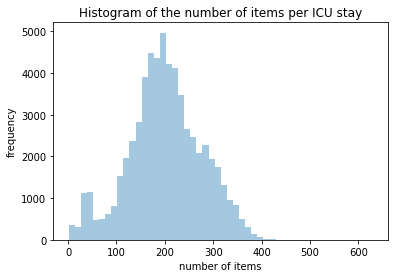

In [11]:
%%time
sns.distplot(agg24h.groupBy("ICUSTAY_ID").agg(F.count("ITEMID").alias('count')).toPandas()['count'], kde=False)

# Add labels
plt.title('Histogram of the number of items per ICU stay')
plt.xlabel('number of items')
plt.ylabel('frequency')

In [19]:
tmp = agg24h.groupBy("ITEMID").agg(F.count("ITEMID").alias('count')).orderBy('count', ascending=False)
tmp.select(F.countDistinct("ITEMID")).show()

+----------------------+
|count(DISTINCT ITEMID)|
+----------------------+
|                  4387|
+----------------------+



In [20]:
# Top 10 items
tmp = tmp.limit(5).alias('tmp')
tmp = d_items.join(tmp, d_items.ITEMID == tmp.ITEMID).select('tmp.ITEMID', 'LABEL', 'tmp.count')\
             .orderBy('count', ascending=False)
tmp.show()

+------+-------------------+-----+
|ITEMID|              LABEL|count|
+------+-------------------+-----+
|   211|         Heart Rate|36770|
|    31|           Activity|35567|
|   926|           Religion|35222|
|    80|       Bowel Sounds|32304|
|   829|Potassium (3.5-5.3)|29087|
+------+-------------------+-----+



CPU times: user 76 ms, sys: 4 ms, total: 80 ms
Wall time: 82.9 ms


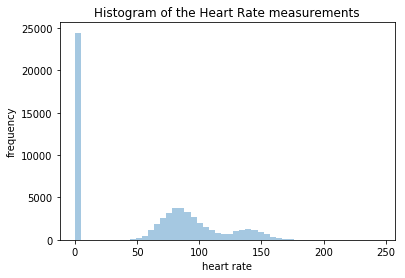

In [17]:
%%time
sns.distplot(icustay_df['211'], kde=False)

# Add labels
plt.title('Histogram of the Heart Rate measurements')
plt.xlabel('heart rate')
plt.ylabel('frequency')

CPU times: user 72 ms, sys: 8 ms, total: 80 ms
Wall time: 79 ms


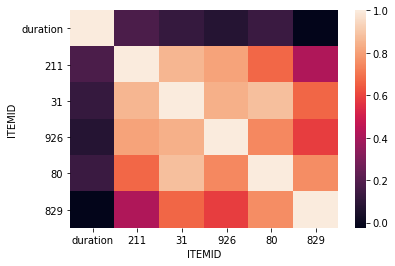

In [24]:
%%time

corr = icustay_df[['duration', '211', '31', '926', '80', '829']].corr()
sns.heatmap(corr)

---

# (9) Prediction model

In [18]:
#!pip install keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, Nadam
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [ ]:
from sklearn.preprocessing import MinMaxScaler
# create scaler
scaler = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scaler.fit(icustay_df)
# apply transform
normalized = scaler.transform(icustay_df)
final_df = pd.DataFrame(normalized, columns=icustay_df.columns, index=icustay_df.index)

In [20]:
target_column = ['duration'] 
unused_columns = ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID']
predictors = list(set(list(final_df.columns))-set(target_column)-set(unused_columns))

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = final_df[predictors].values
y = final_df[target_column].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
print(X_train.shape); print(X_test.shape)

(42910, 4387)
(18391, 4387)


In [39]:
# Define model
model = Sequential()

# The Hidden Layer :
model.add(Dense(128, input_dim = X_train.shape[1], activation='relu'))

# The Output Layer :
model.add(Dense(1, activation='linear'))

# Compile the network :
model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mean_squared_error'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 128)               561664    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
Total params: 561,793
Trainable params: 561,793
Non-trainable params: 0
_________________________________________________________________


In [40]:
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=15,
                    verbose=1,
                    validation_data=(X_test, y_test))

Train on 42910 samples, validate on 18391 samples
Epoch 1/15
42910/42910 [==============================] - 11s 248us/step - loss: 0.2839 - mean_squared_error: 0.2839 - val_loss: 0.0095 - val_mean_squared_error: 0.0095
Epoch 2/15
42910/42910 [==============================] - 10s 230us/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 3/15
42910/42910 [==============================] - 10s 228us/step - loss: 0.0089 - mean_squared_error: 0.0089 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 4/15
42910/42910 [==============================] - 10s 228us/step - loss: 0.0088 - mean_squared_error: 0.0088 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 5/15
42910/42910 [==============================] - 10s 235us/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 6/15
42910/42910 [==============================] - 10s 228us/step - loss: 0.0079 - mean_squared_er

In [41]:
scores = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', scores[1])

Test accuracy: 0.0066115863224317575


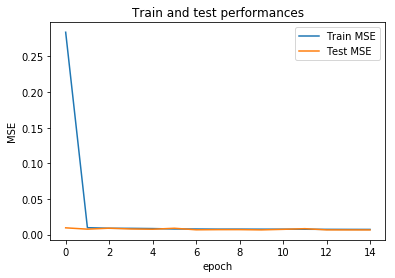

In [42]:
import matplotlib.pyplot as plt
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])

plt.title('Train and test performances')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['Train MSE', 'Test MSE'], loc='upper right')

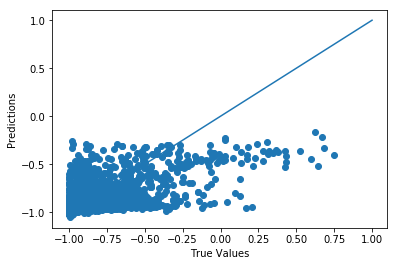

In [43]:
test_predictions = model.predict(X_test)

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
_ = plt.plot([-1, 1], [-1, 1])

---